Right now results are for one event, this is a test case for adaptation to another event (just need reliable edge data on hand for the same)

In [1]:
import numpy as np
import pandas as pd

In [2]:
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
import tqdm
import gpytorch
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.distributions import MultivariateNormal
from gpytorch.models import ApproximateGP, GP
from gpytorch.mlls import VariationalELBO, AddedLossTerm
from gpytorch.likelihoods import GaussianLikelihood

from sklearn.preprocessing import StandardScaler
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL

from matplotlib import pyplot as plt

In [5]:
import re
import os

In [6]:
%matplotlib inline

In [7]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
plt.style.use("dark_background")

In [8]:
import edge_utils as edut

Load data

In [9]:
ed_2161, sd_2161 = edut.load_edge_data_blobfree(2161)

In [10]:
nTimes, nTheta_2161, nSims_2161 = ed_2161.shape
nTimes, nTheta_2161, nSims_2161

(90, 160, 278)

In [11]:
theta_s_2161, theta_e_2161 = np.linspace(0, 360, 512)[160] + 1.2 * 180 - 360, np.linspace(0, 360, 512)[320] + 1.2 * 180 - 360
print("Range of angles for CR2161: {} {}".format(theta_s_2161, theta_e_2161))

Range of angles for CR2161: -31.279843444227026 81.44031311154595


In [12]:
theta_grid = np.linspace(np.ceil(theta_s_2161), np.ceil(theta_e_2161), nTheta_2161)

Least Squares Fit (don't need non-linear because of independence of $k$ and $\tau$.

In [13]:
def getRValuesAllSims(edge_data_matrix):
    """
    Return r values for all sims at once so we don't lose time in training processing r values repeatedly
    """
    r_data_matrix = np.zeros(edge_data_matrix.shape)
    nsims = edge_data_matrix.shape[2]
    for i in range(nsims):
        r_vals, theta_vals = edut.getRValues(edge_data_matrix, simIdx=i, minStartIdx=0)
        r_data_matrix[:, :, i] = r_vals

    return r_data_matrix

In [14]:
# we are removing some data where the edge detection is not necessarily super reliable.
sims_to_remove = np.array([33, 39, 63, 73, 113, 128, 131, 142, 193, 218, 253, 264, 273, 312, 313, 324])

In [15]:
sd_modified = np.setdiff1d(sd_2161, sims_to_remove)

In [16]:
cme_params = pd.read_csv("./restarts_CR2161.csv")
cme_params.head()

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,restartdir,realization
0,0.58375,22.526622,0.682075,204.725,1,4,4
1,0.52625,6.919483,0.519179,164.225,1,4,4
2,0.72625,5.087500,0.662022,233.975,1,4,4
3,0.36125,18.360770,0.420743,200.675,-1,4,4
4,0.69125,8.127120,0.735101,184.925,1,4,4


In [17]:
bg_params = pd.read_csv("./backgrounds_CR2161.csv")
bg_params

,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
0,0.5987,547686.9,259077.5
1,0.6876,514248.2,170240.5
2,0.7334,437169.7,242477.4
3,0.8010,378833.7,147856.5
4,0.9431,491082.5,205150.8
5,1.0077,349735.7,230084.9
6,1.0404,668772.0,278163.0
7,1.0921,463650.6,299730.0
8,1.2009,337215.4,113682.7
9,1.2292,583776.3,160912.2


In [18]:
unique_bg = cme_params.restartdir.unique()
unique_bg

array([ 4, 12])

In [19]:
cme_param_bg_idx = []
for bg in unique_bg:
    cme_param_bg_idx.append(np.array((cme_params.restartdir == bg).to_list()))

In [20]:
bg_params_to_insert = np.zeros((cme_params.shape[0], bg_params.shape[1]))
for bg_idx, bg in enumerate(unique_bg):
    bg_params_to_insert[cme_param_bg_idx[bg_idx], 0] = bg_params.FactorB0[bg - 1]
    bg_params_to_insert[cme_param_bg_idx[bg_idx], 1] = bg_params.PoyntingFluxPerBSi[bg - 1]
    bg_params_to_insert[cme_param_bg_idx[bg_idx], 2] = bg_params.LperpTimesSqrtBSi[bg - 1]

cme_params["FactorB0"] = pd.Series(bg_params_to_insert[:, 0])
cme_params["PoyntingFluxPerBSi"] = pd.Series(bg_params_to_insert[:, 1])
cme_params["LperpTimesSqrtBSi"] = pd.Series(bg_params_to_insert[:, 2])
cme_params["SimID"] = pd.Series(np.linspace(31, 330, 300))
sim_idx_successful = sd_2161 - 30 - 1
sim_idx_to_drop = np.setdiff1d(np.linspace(0, 299, 300), sim_idx_successful).astype(int).tolist()


cme_params.drop(["restartdir"], axis=1, inplace=True)
cme_params.drop(sim_idx_to_drop, inplace=True)
cme_params.drop(["SimID"], axis=1, inplace=True)
cme_params

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,realization,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
0,0.58375,22.526622,0.682075,204.725,1,4,0.8010,378833.7,147856.5
1,0.52625,6.919483,0.519179,164.225,1,4,0.8010,378833.7,147856.5
2,0.72625,5.087500,0.662022,233.975,1,4,0.8010,378833.7,147856.5
3,0.36125,18.360770,0.420743,200.675,-1,4,0.8010,378833.7,147856.5
4,0.69125,8.127120,0.735101,184.925,1,4,0.8010,378833.7,147856.5
...,...,...,...,...,...,...,...,...,...
294,0.73750,15.331483,0.721367,170.750,-1,5,1.3016,304514.4,283042.3
295,0.36250,32.665259,0.436133,197.750,-1,5,1.3016,304514.4,283042.3
296,0.46250,26.757500,0.443711,224.750,1,5,1.3016,304514.4,283042.3
297,0.76250,16.930533,0.874492,215.750,-1,5,1.3016,304514.4,283042.3


In [21]:
cme_p_min = cme_params.min()
cme_p_min.BStrength = 4.4516
cme_p_min.Radius = 0.3
cme_p_min.OrientationCme = 155
cme_p_min.iHelicity = -1
cme_p_min.ApexHeight = 0.2625
cme_p_min.realization = 1
cme_p_min.FactorB0 = 0.54
cme_p_min.PoyntingFluxPerBSi = 0.3e6
cme_p_min.LperpTimesSqrtBSi = 0.3e5

cme_p_min

Radius                     0.3000
BStrength                  4.4516
ApexHeight                 0.2625
OrientationCme           155.0000
iHelicity                 -1.0000
realization                1.0000
FactorB0                   0.5400
PoyntingFluxPerBSi    300000.0000
LperpTimesSqrtBSi      30000.0000
dtype: float64

In [22]:
cme_p_max = cme_params.max()
cme_p_max.BStrength = 47.4833
cme_p_max.Radius = 0.8
cme_p_max.OrientationCme = 245
cme_p_max.iHelicity = 1
cme_p_max.ApexHeight = 1
cme_p_max.realization = 12
cme_p_max.FactorB0 = 2.7
cme_p_max.PoyntingFluxPerBSi = 1.1e6
cme_p_max.LperpTimesSqrtBSi = 3e5

cme_p_max

Radius                8.000000e-01
BStrength             4.748330e+01
ApexHeight            1.000000e+00
OrientationCme        2.450000e+02
iHelicity             1.000000e+00
realization           1.200000e+01
FactorB0              2.700000e+00
PoyntingFluxPerBSi    1.100000e+06
LperpTimesSqrtBSi     3.000000e+05
dtype: float64

In [23]:
cme_params_norm = (cme_params - cme_p_min) / (cme_p_max - cme_p_min)
cme_params_norm

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,realization,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
0,0.5675,0.420040,0.568916,0.5525,1.0,0.272727,0.120833,0.098542,0.436506
1,0.4525,0.057350,0.348039,0.1025,1.0,0.272727,0.120833,0.098542,0.436506
2,0.8525,0.014777,0.541725,0.8775,1.0,0.272727,0.120833,0.098542,0.436506
3,0.1225,0.323231,0.214567,0.5075,0.0,0.272727,0.120833,0.098542,0.436506
4,0.7825,0.085414,0.640815,0.3325,1.0,0.272727,0.120833,0.098542,0.436506
...,...,...,...,...,...,...,...,...,...
294,0.8750,0.252834,0.622193,0.1750,0.0,0.363636,0.352593,0.005643,0.937194
295,0.1250,0.655648,0.235434,0.4750,0.0,0.363636,0.352593,0.005643,0.937194
296,0.3250,0.518360,0.245710,0.7750,1.0,0.363636,0.352593,0.005643,0.937194
297,0.9250,0.289994,0.829820,0.6750,0.0,0.363636,0.352593,0.005643,0.937194


In [24]:
cme_params_to_augment = cme_params_norm.to_numpy()
cme_params_to_augment.shape

(278, 9)

In [25]:
rd_2161 = getRValuesAllSims(ed_2161)

In [26]:
data_dim = rd_2161.shape[1]
data_dim

160

In [27]:
param_dim = cme_params_to_augment.shape[1]
param_dim

9

In [28]:
augmented_r = np.zeros((rd_2161.shape[0], data_dim + param_dim, rd_2161.shape[2]))
augmented_r[:, :(data_dim), :] = rd_2161
for iii in range(rd_2161.shape[2]):
    augmented_r[:, (data_dim):, iii] = cme_params_to_augment[iii, :]

In [29]:
def lin_velocity_func(x, t, y):
    return x[0] * t - y

In [30]:
def gen_velocities(t, c1):
    return c1 * t

In [31]:
from scipy.optimize import least_squares

In [32]:
def fit_velocity(edge_data_matrix, 
                 sim_data, simIdx=0, 
                theta=np.linspace(-31, 82, 160), 
                lsq_loss="soft_l1",
                fscale=0.1,
                x0 = [0.00517464 * 400]):
    """
    for a chosen sim ID, fit least squares to all valid times in edge data, varying with position angle.
    return matrix of size (n_theta x n_params), here n_params = 1
    """
    
    ntheta = len(theta)
    
    simID = sim_data[simIdx]
    
    tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(edge_data_matrix, simIdx=simIdx)
    
    r_vals, theta_vals = edut.getRValues(edge_data_matrix, simIdx=simIdx, minStartIdx=0)
    
    # sim times (list all times)
    all_times = np.linspace(2, 180, 90)
    
    # filter based on tMinIdx and tMaxIdx
    valid_times = all_times[tMinIdx:(tMaxIdx + 1)]
    
    valid_time_idx = np.array([np.where(all_times == i)[0][0] for i in valid_times])
    
    # rescale valid_times
    # convert time to hours from minutes
    #     valid_times_hrs = valid_times / 60
    valid_times_rs = (valid_times - tMin) / (tMax - tMin)
    
    lsq_params = np.zeros((ntheta, 1))
    
    r_vals_valid = r_vals[valid_time_idx, :]
    
    r0 = r_vals_valid[0, :]
    
    
    t_train = valid_times_rs[1:]
    r_train = r_vals_valid[1:, :] - r0
    
    r_pred = np.zeros(np.shape(r_vals_valid))
    
    r_pred[0, :] = r0
    
    for pa_idx, pa in enumerate(theta):
        res_lsq = least_squares(lin_velocity_func,
                                x0,
                                loss=lsq_loss,
                                args=(t_train, r_train[:, pa_idx]),
                                bounds=(0, np.inf),
                                verbose=0)
        
        
        lsq_params[pa_idx, :] = res_lsq.x
        r_pred[1:, pa_idx] = gen_velocities(t_train, *res_lsq.x) + r0[pa_idx]
    
    return lsq_params, r_pred, r_vals_valid

In [33]:
params_s0, r_pred_s0, r_vals_s0 = fit_velocity(ed_2161, sd_2161, simIdx=0, lsq_loss="linear")

In [34]:
params_s0

array([[11.70298974],
       [11.75174197],
       [11.80414071],
       [11.86005838],
       [11.91936735],
       [11.98193999],
       [12.04764864],
       [12.11636562],
       [12.18796323],
       [12.26231375],
       [12.33928945],
       [12.41876257],
       [12.50060537],
       [12.58469004],
       [12.67088882],
       [12.7590739 ],
       [12.84911747],
       [12.94089172],
       [13.03426883],
       [13.12912097],
       [13.2253203 ],
       [13.32273901],
       [13.42124925],
       [13.52072319],
       [13.62103301],
       [13.72205087],
       [13.82329836],
       [13.92477486],
       [14.02623723],
       [14.12765224],
       [14.22923373],
       [14.33091225],
       [14.43252015],
       [14.53393567],
       [14.63495484],
       [14.73536656],
       [14.83505377],
       [14.933958  ],
       [15.03194298],
       [15.1291078 ],
       [15.22538042],
       [15.32063338],
       [15.41478502],
       [15.50790096],
       [15.59984102],
       [15

In [35]:
c1_params = np.zeros((160, 1, len(sd_modified)))
for i in range(len(sd_modified)):
    params_sheeley, r_pred_sheeley, r_vals_sheeley = fit_velocity(ed_2161, 
                                                                  sd_modified, 
                                                                  simIdx=i, 
                                                                  lsq_loss="soft_l1")
    
    c1_params[:, :, i] = params_sheeley
#     edut.plotTrainPredData1Model(r_vals_sheeley, r_pred_sheeley, ed_2161, sd_modified, simIdx=i, 
#                                   savefig=True,
#                                   savedir="./linear_velocity_fit_all_sims"
#                                  )

Text(0.5, 1.0, 'c1 selected')

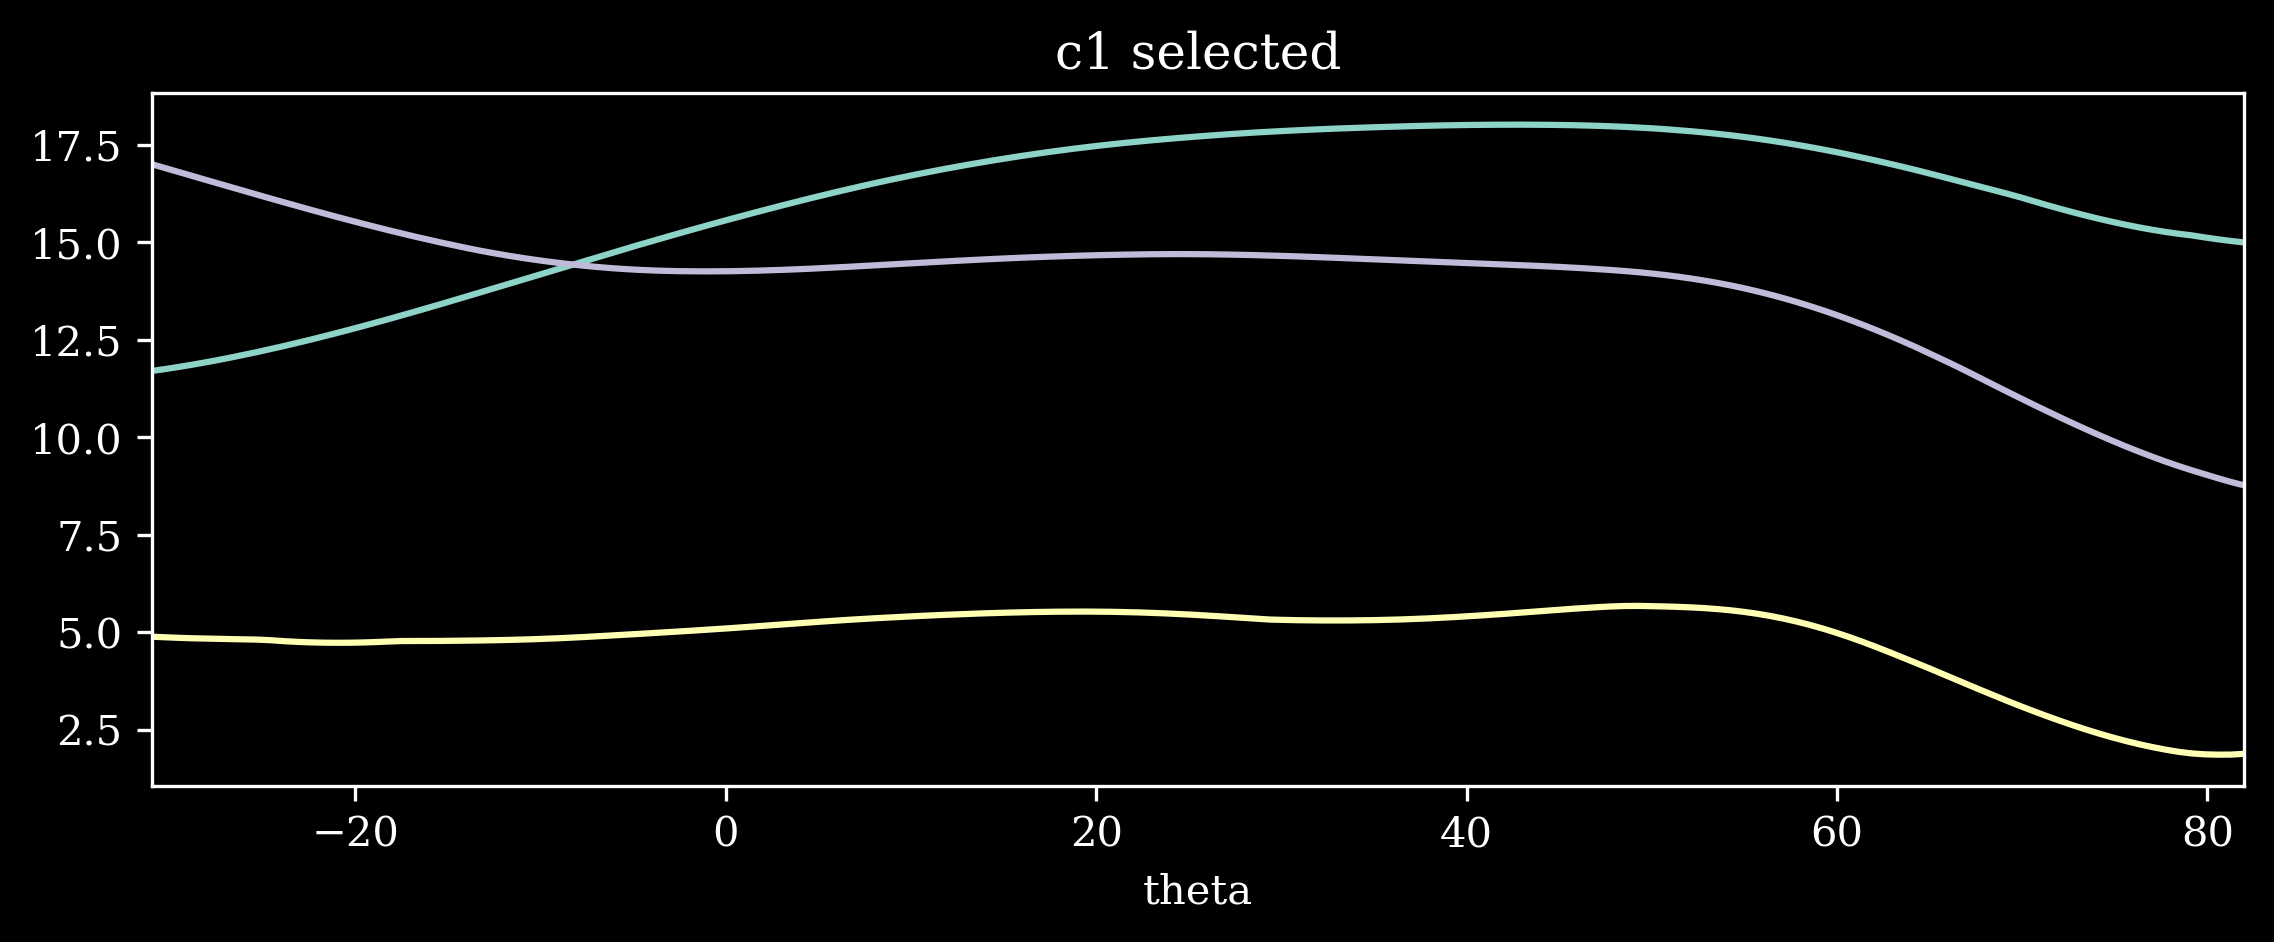

In [36]:
plt.plot(np.linspace(-31, 82, 160), np.squeeze(c1_params)[:, 0], label="")
plt.plot(np.linspace(-31, 82, 160), np.squeeze(c1_params)[:, 1], label="")
plt.plot(np.linspace(-31, 82, 160), np.squeeze(c1_params)[:, 20], label="")
plt.xlabel("theta")
plt.xlim((-31, 82))
plt.title("c1 selected")

In [37]:
from numpy.random import Generator, PCG64
rng = Generator(PCG64())

nTrain = int(np.floor(0.6 * len(sd_modified)))
nCalib = int(np.floor(0.2 * len(sd_modified)))
nTest = len(sd_modified) - nTrain - nCalib

nTrain, nTest, nCalib

(157, 53, 52)

In [38]:
len(sd_modified)

262

In [39]:
orig_sd_idx = np.array([np.where(sd_2161 == i)[0][0] for i in sd_modified])

In [40]:
sd_train = np.sort(np.random.choice(sd_modified, nTrain, replace=False))
sd_test_calib = np.setdiff1d(sd_modified, sd_train)
sd_calib = np.sort(np.random.choice(sd_test_calib, nCalib, replace=False))
sd_test = np.setdiff1d(sd_test_calib, sd_calib)

sd_test, sd_calib

(array([ 31,  34,  47,  50,  56,  74,  79,  89,  92,  95,  99, 101, 104,
        106, 108, 120, 121, 122, 136, 141, 145, 147, 151, 154, 158, 160,
        174, 179, 196, 209, 215, 219, 224, 237, 240, 241, 246, 247, 251,
        258, 266, 272, 277, 281, 283, 286, 291, 297, 301, 314, 315, 316,
        321]),
 array([ 38,  40,  42,  49,  68,  70,  72,  78, 110, 134, 140, 152, 153,
        163, 171, 172, 175, 176, 177, 180, 184, 198, 199, 201, 202, 206,
        212, 213, 217, 234, 235, 236, 242, 244, 252, 255, 262, 269, 276,
        278, 282, 284, 290, 293, 295, 300, 302, 305, 311, 319, 323, 327]))

In [41]:
train_sd_idx = np.array([np.where(sd_2161 == i)[0][0] for i in sd_train])
test_sd_idx  = np.array([np.where(sd_2161 == i)[0][0] for i in sd_test])

In [42]:
train_sd_idx_modified = np.array([np.where(sd_modified == i)[0][0] for i in sd_train])

In [43]:
test_sd_idx_modified = np.array([np.where(sd_modified == i)[0][0] for i in sd_test])

GPs?? (tried a few other things including Normalizing Flows, but decided to go with tried and tested for now)

In [44]:
# Fist try with simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# likelihood = gpytorch.likelihoods.GaussianLikelihood()
# model = ExactGPModel(train_x, train_y, likelihood)

In [45]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [46]:
theta_grid[0::2].shape

(80,)

In [47]:
theta_grid_scaled = (theta_grid[0::2] - theta_grid[0])/(theta_grid[-1] - theta_grid[0])

In [48]:
theta_grid_scaled.shape

(80,)

In [49]:
theta_repeat = np.tile(theta_grid_scaled, len(train_sd_idx))
theta_repeat.shape

(12560,)

In [50]:
cme_params_to_augment.shape

(278, 9)

Check indexing

In [51]:
train_x_raw = cme_params_to_augment[train_sd_idx, :]
test_x_raw = cme_params_to_augment[test_sd_idx, :]

In [52]:
train_x_raw.shape

(157, 9)

In [53]:
train_x_repeat = np.repeat(train_x_raw, len(theta_grid_scaled), axis=0)
train_x_repeat.shape

(12560, 9)

In [54]:
test_x_repeat = np.repeat(test_x_raw, len(theta_grid_scaled), axis=0)
test_x_repeat.shape

(4240, 9)

In [55]:
train_x_final = np.c_[theta_repeat, train_x_repeat]

In [56]:
train_x_final.shape

(12560, 10)

In [57]:
train_x_torch = torch.tensor(np.float32(train_x_final)).to(device)

In [58]:
test_x_final = np.c_[np.tile(theta_grid_scaled, len(test_sd_idx)), test_x_repeat]

In [59]:
test_x_final.shape

(4240, 10)

In [60]:
test_x_torch = torch.tensor(np.float32(test_x_final)).to(device)

In [61]:
c1_params_2d = np.squeeze(c1_params)
c1_params_2d.shape

(160, 262)

In [62]:
train_y = c1_params_2d[0::2, train_sd_idx_modified].T.flatten()
train_y.shape

(12560,)

In [63]:
test_y = c1_params_2d[0::2, test_sd_idx_modified].T.flatten()
test_y.shape

(4240,)

In [64]:
train_y_torch = torch.tensor(np.float32(train_y)).to(device)

In [65]:
train_y_torch.shape

torch.Size([12560])

In [66]:
test_y_torch = torch.tensor(np.float32(test_y)).to(device)

In [67]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# model = ExactGPModel(train_x_torch, train_y_torch, likelihood)
model = ExactGPModel(train_x_torch, train_y_torch, likelihood)

In [68]:
training_iters = 500

In [69]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

Need to rethink settings for GP - approximate GPs with inducing points, deep GPs, kernel? (very long training times even with half the position angles)

In [70]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [71]:
for i in range(training_iters):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x_torch)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y_torch)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iters, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/500 - Loss: 8.604   lengthscale: 0.693   noise: 0.693
Iter 2/500 - Loss: 7.556   lengthscale: 0.644   noise: 0.744
Iter 3/500 - Loss: 6.602   lengthscale: 0.598   noise: 0.798
Iter 4/500 - Loss: 5.733   lengthscale: 0.554   noise: 0.852
Iter 5/500 - Loss: 4.951   lengthscale: 0.513   noise: 0.906
Iter 6/500 - Loss: 4.262   lengthscale: 0.474   noise: 0.960
Iter 7/500 - Loss: 3.666   lengthscale: 0.438   noise: 1.012
Iter 8/500 - Loss: 3.185   lengthscale: 0.404   noise: 1.061
Iter 9/500 - Loss: 2.793   lengthscale: 0.373   noise: 1.107
Iter 10/500 - Loss: 2.490   lengthscale: 0.345   noise: 1.149
Iter 11/500 - Loss: 2.277   lengthscale: 0.320   noise: 1.188
Iter 12/500 - Loss: 2.116   lengthscale: 0.297   noise: 1.223
Iter 13/500 - Loss: 2.005   lengthscale: 0.277   noise: 1.253
Iter 14/500 - Loss: 1.928   lengthscale: 0.259   noise: 1.281
Iter 15/500 - Loss: 1.875   lengthscale: 0.244   noise: 1.305
Iter 16/500 - Loss: 1.840   lengthscale: 0.230   noise: 1.325
Iter 17/500 - Los

Iter 133/500 - Loss: -0.152   lengthscale: 0.189   noise: 0.037
Iter 134/500 - Loss: -0.169   lengthscale: 0.190   noise: 0.035
Iter 135/500 - Loss: -0.196   lengthscale: 0.190   noise: 0.033
Iter 136/500 - Loss: -0.214   lengthscale: 0.190   noise: 0.031
Iter 137/500 - Loss: -0.235   lengthscale: 0.190   noise: 0.029
Iter 138/500 - Loss: -0.257   lengthscale: 0.191   noise: 0.027
Iter 139/500 - Loss: -0.269   lengthscale: 0.191   noise: 0.025
Iter 140/500 - Loss: -0.295   lengthscale: 0.191   noise: 0.024
Iter 141/500 - Loss: -0.306   lengthscale: 0.191   noise: 0.022
Iter 142/500 - Loss: -0.321   lengthscale: 0.192   noise: 0.021
Iter 143/500 - Loss: -0.344   lengthscale: 0.192   noise: 0.019
Iter 144/500 - Loss: -0.367   lengthscale: 0.192   noise: 0.018
Iter 145/500 - Loss: -0.369   lengthscale: 0.192   noise: 0.017
Iter 146/500 - Loss: -0.395   lengthscale: 0.192   noise: 0.016
Iter 147/500 - Loss: -0.416   lengthscale: 0.192   noise: 0.015
Iter 148/500 - Loss: -0.428   lengthscal

Iter 262/500 - Loss: -0.606   lengthscale: 0.186   noise: 0.000
Iter 263/500 - Loss: -0.571   lengthscale: 0.188   noise: 0.000
Iter 264/500 - Loss: -0.548   lengthscale: 0.189   noise: 0.000


KeyboardInterrupt: 

**Metrics?**
Sure, MSEs and $R^2$ style metrics, but also MLL scores ? compare accuracy of different models in high-confidence and low-confidence predictions?

In [72]:
def predict(gp_model, x_data, y_data):
    with torch.no_grad():
        mus = []
        variances = []
            
        preds = gp_model.likelihood(gp_model(x_data))
        mus.append(preds.mean)
        variances.append(preds.variance)

    return torch.cat(mus, dim=-1), torch.cat(variances, dim=-1)

In [73]:
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [74]:
sd_test

array([ 31,  34,  47,  50,  56,  74,  79,  89,  92,  95,  99, 101, 104,
       106, 108, 120, 121, 122, 136, 141, 145, 147, 151, 154, 158, 160,
       174, 179, 196, 209, 215, 219, 224, 237, 240, 241, 246, 247, 251,
       258, 266, 272, 277, 281, 283, 286, 291, 297, 301, 314, 315, 316,
       321])

In [75]:
len(sd_test)

53

In [76]:
np.linspace(0, 4240, 54)

array([   0.,   80.,  160.,  240.,  320.,  400.,  480.,  560.,  640.,
        720.,  800.,  880.,  960., 1040., 1120., 1200., 1280., 1360.,
       1440., 1520., 1600., 1680., 1760., 1840., 1920., 2000., 2080.,
       2160., 2240., 2320., 2400., 2480., 2560., 2640., 2720., 2800.,
       2880., 2960., 3040., 3120., 3200., 3280., 3360., 3440., 3520.,
       3600., 3680., 3760., 3840., 3920., 4000., 4080., 4160., 4240.])

In [77]:
test_y_torch[0:80]

tensor([11.7025, 11.8036, 11.9189, 12.0473, 12.1877, 12.3391, 12.5005, 12.6708,
        12.8491, 13.0342, 13.2253, 13.4212, 13.6210, 13.8233, 14.0264, 14.2295,
        14.4330, 14.6357, 14.8360, 15.0332, 15.2268, 15.4165, 15.6017, 15.7820,
        15.9578, 16.1281, 16.2922, 16.4489, 16.5975, 16.7375, 16.8692, 16.9922,
        17.1068, 17.2135, 17.3118, 17.4013, 17.4822, 17.5549, 17.6197, 17.6778,
        17.7309, 17.7794, 17.8219, 17.8589, 17.8912, 17.9195, 17.9442, 17.9657,
        17.9850, 18.0007, 18.0118, 18.0182, 18.0200, 18.0161, 18.0067, 17.9893,
        17.9629, 17.9266, 17.8786, 17.8188, 17.7462, 17.6600, 17.5594, 17.4443,
        17.3158, 17.1746, 17.0221, 16.8600, 16.6878, 16.5124, 16.3359, 16.1549,
        15.9569, 15.7717, 15.6026, 15.4524, 15.3243, 15.2218, 15.1280, 15.0368])

In [78]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x_torch))

/Users/ajivani/opt/anaconda3/lib/python3.8/site-packages/linear_operator/utils/linear_cg.py:337: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.13404743373394012 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Return 2 standard deviations above and below the mean using `confidence_region` and Lanczos estimate of predictive variance

In [79]:
lower, upper = observed_pred.confidence_region()

In [80]:
mean_pred = observed_pred.mean.numpy()
mean_pred.shape

(4240,)

Text(0, 0.5, 'c1')

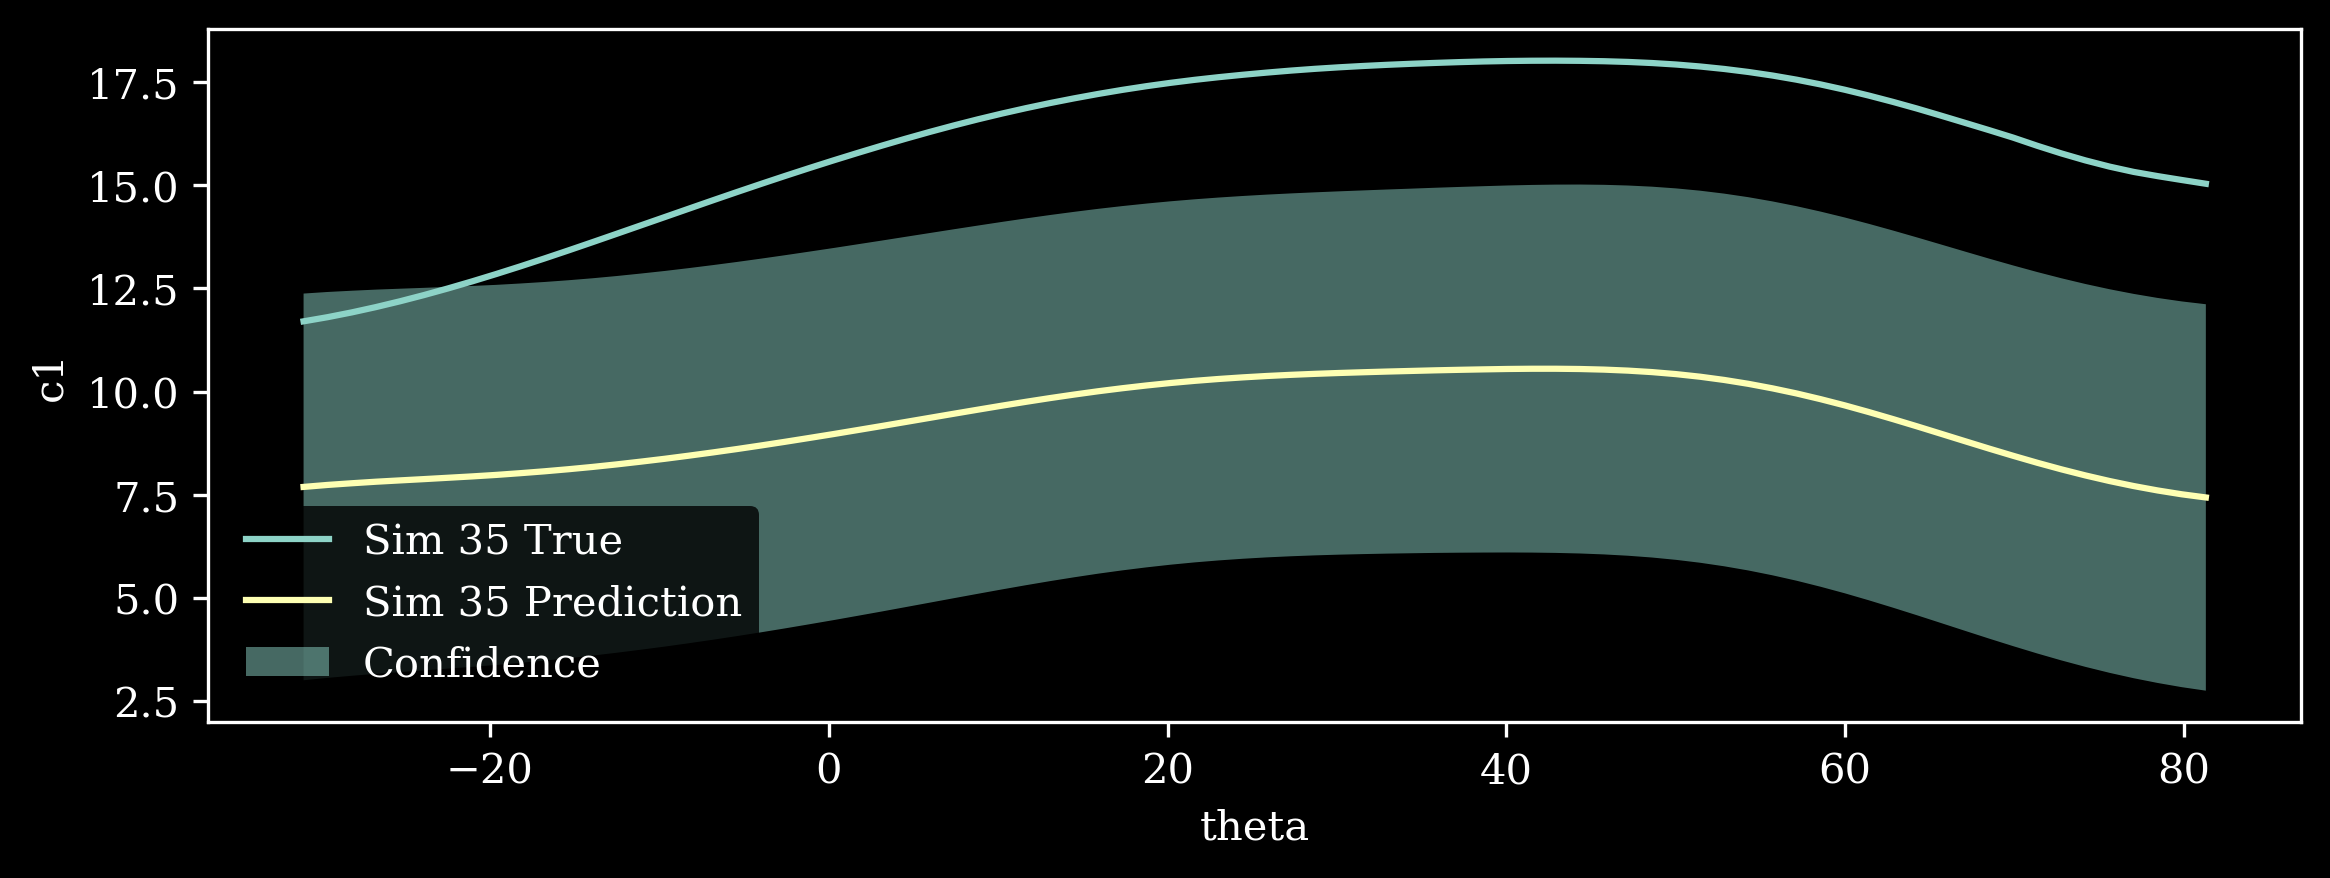

In [81]:
plt.plot(theta_grid[0::2], test_y_torch[0:80], label="Sim 35 True")
plt.plot(theta_grid[0::2], mean_pred[0:80], label="Sim 35 Prediction")

plt.fill_between(theta_grid[0::2], lower[0:80], upper[0:80], alpha=0.5, label="Confidence")

plt.legend()

plt.xlabel("theta")
plt.ylabel("c1")

Text(0, 0.5, 'c1')

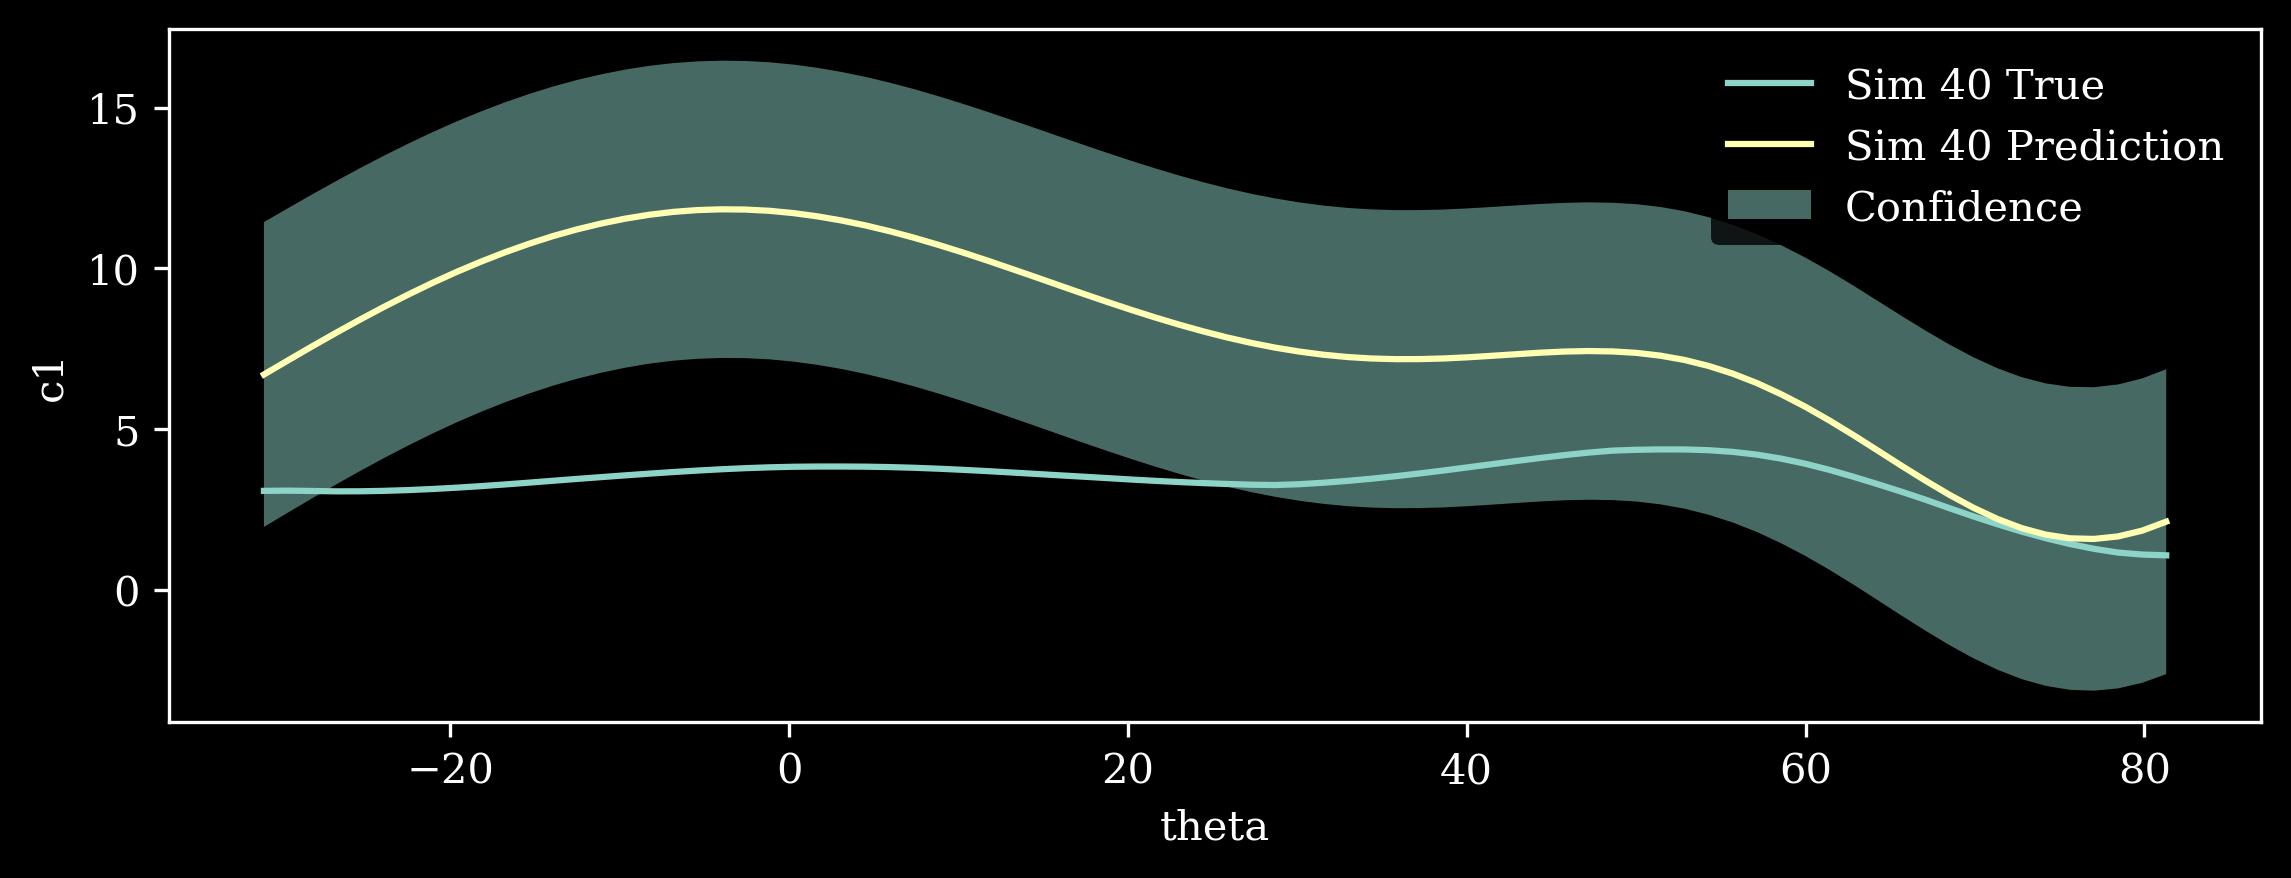

In [82]:
plt.plot(theta_grid[0::2], test_y_torch[160:240], label="Sim 40 True")
plt.plot(theta_grid[0::2], mean_pred[160:240], label="Sim 40 Prediction")

plt.fill_between(theta_grid[0::2], lower[160:240], upper[160:240], alpha=0.5, label="Confidence")

plt.legend()

plt.xlabel("theta")
plt.ylabel("c1")

Text(0, 0.5, 'c1')

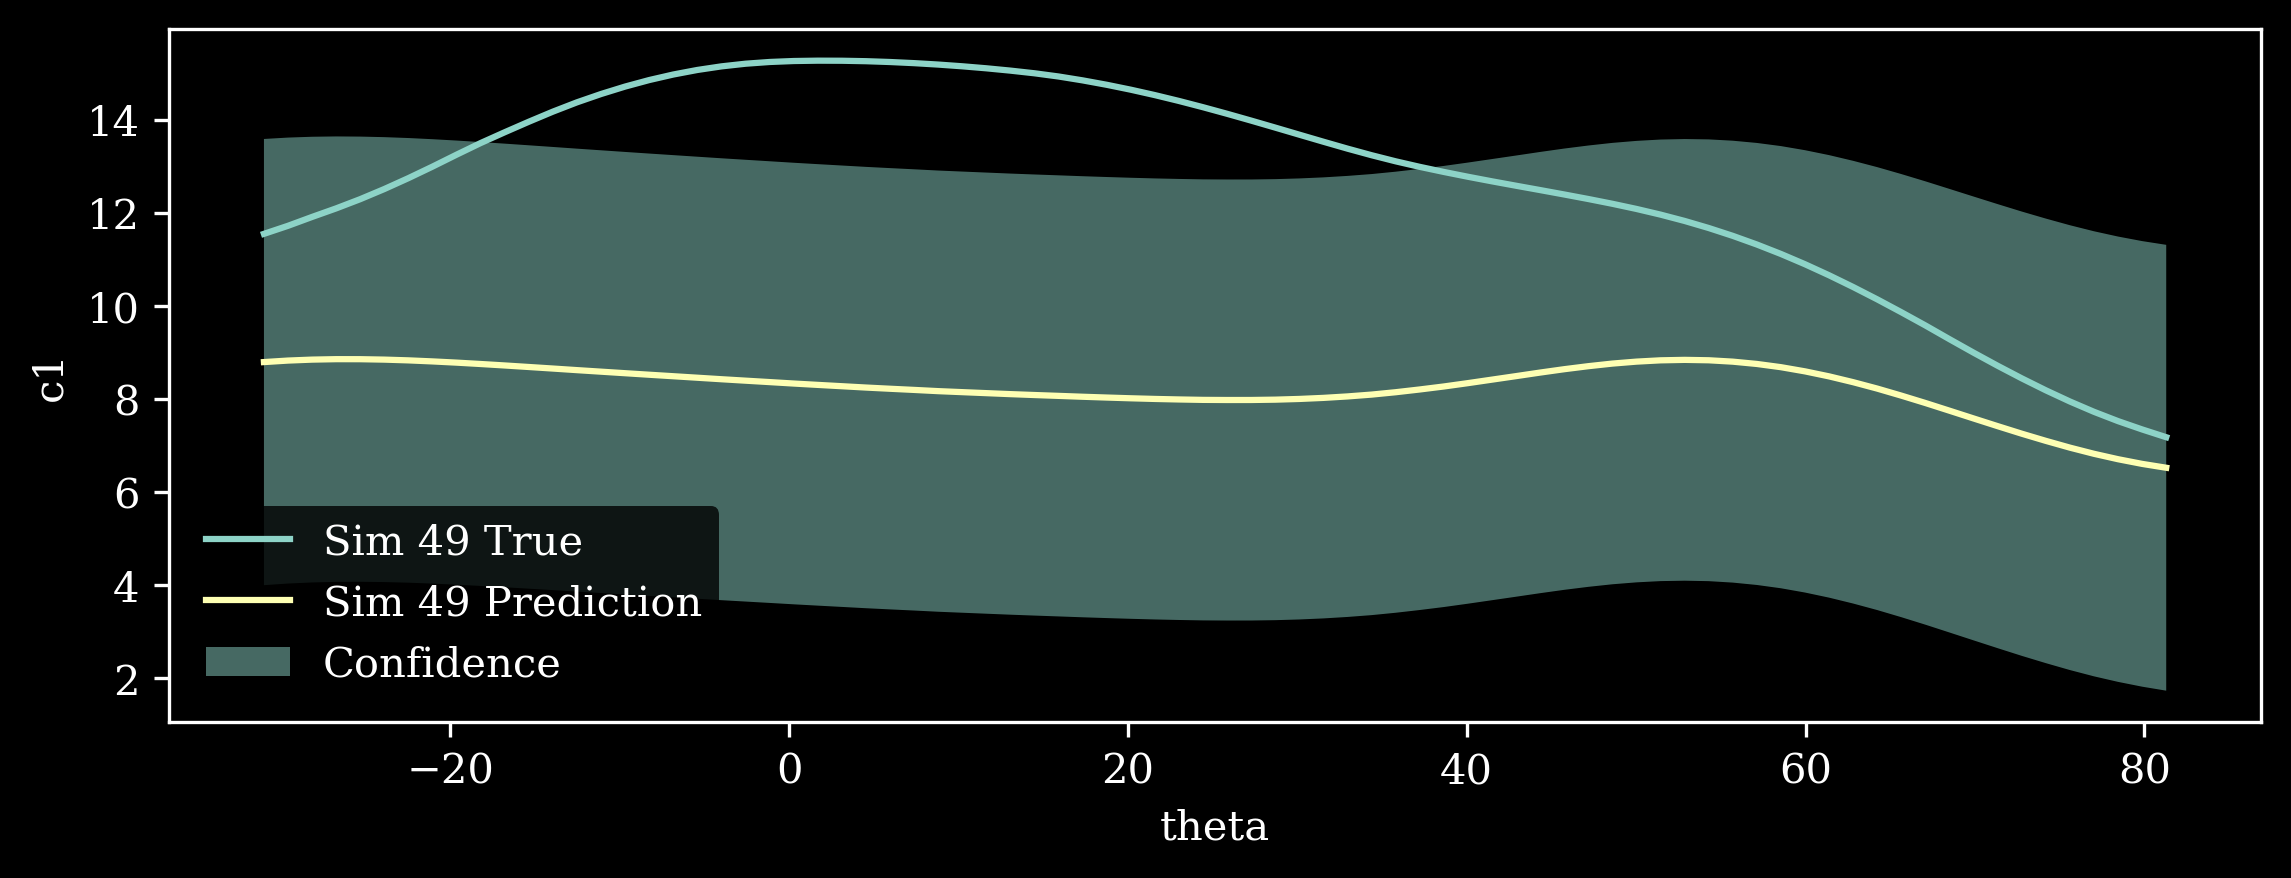

In [83]:
plt.plot(theta_grid[0::2], test_y_torch[320:400], label="Sim 49 True")
plt.plot(theta_grid[0::2], mean_pred[320:400], label="Sim 49 Prediction")

plt.fill_between(theta_grid[0::2], lower[320:400], upper[320:400], alpha=0.5, label="Confidence")

plt.legend()

plt.xlabel("theta")
plt.ylabel("c1")

Text(0, 0.5, 'c1')

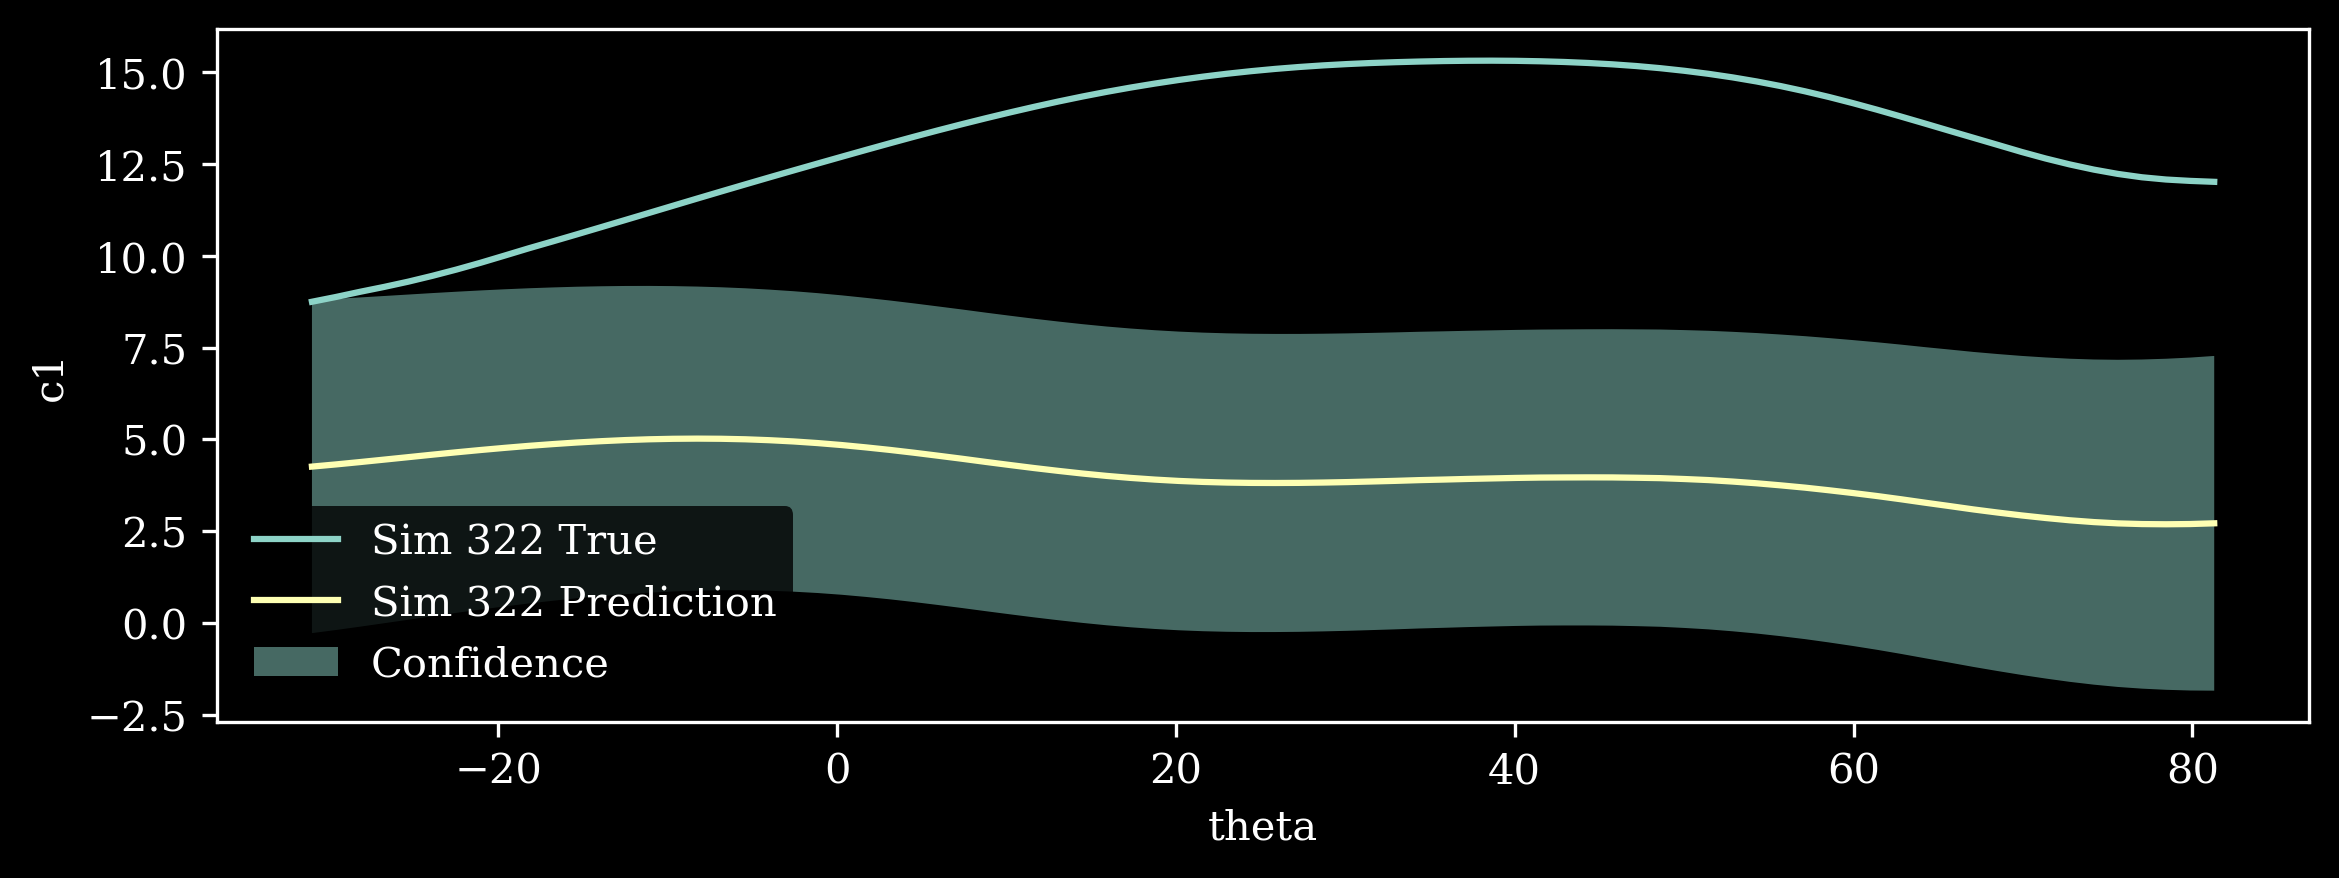

In [84]:
plt.plot(theta_grid[0::2], test_y_torch[4160:4240], label="Sim 322 True")
plt.plot(theta_grid[0::2], mean_pred[4160:4240], label="Sim 322 Prediction")

plt.fill_between(theta_grid[0::2], lower[4160:4240], upper[4160:4240], alpha=0.5, label="Confidence")

plt.legend()

plt.xlabel("theta")
plt.ylabel("c1")

In [ ]:
# lower.shape, upper.shape

In [ ]:
help(gpytorch.settings.fast_pred_var())

Conditional predictions?

**Linear Interpolators?**

**Conformalized Predictions**

In [ ]:
# class ToyDeepGPHiddenLayer(DeepGPLayer):
#     def __init__(self, input_dims, output_dims, num_inducing=128, mean_type='constant'):
#         if output_dims is None:
#             inducing_points = torch.randn(num_inducing, input_dims)
#             batch_shape = torch.Size([])
#         else:
#             inducing_points = torch.randn(output_dims, num_inducing, input_dims)
#             batch_shape = torch.Size([output_dims])

#         variational_distribution = CholeskyVariationalDistribution(
#             num_inducing_points=num_inducing,
#             batch_shape=batch_shape
#         )

#         variational_strategy = VariationalStrategy(
#             self,
#             inducing_points,
#             variational_distribution,
#             learn_inducing_locations=True
#         )

#         super(ToyDeepGPHiddenLayer, self).__init__(variational_strategy, input_dims, output_dims)

#         if mean_type == 'constant':
#             self.mean_module = ConstantMean(batch_shape=batch_shape)
#         else:
#             self.mean_module = LinearMean(input_dims)
#         self.covar_module = ScaleKernel(
#             RBFKernel(batch_shape=batch_shape, ard_num_dims=input_dims),
#             batch_shape=batch_shape, ard_num_dims=None
#         )

#     def forward(self, x):
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return MultivariateNormal(mean_x, covar_x)

#     def __call__(self, x, *other_inputs, **kwargs):
#         """
#         Overriding __call__ isn't strictly necessary, but it lets us add concatenation based skip connections
#         easily. For example, hidden_layer2(hidden_layer1_outputs, inputs) will pass the concatenation of the first
#         hidden layer's outputs and the input data to hidden_layer2.
#         """
#         if len(other_inputs):
#             if isinstance(x, gpytorch.distributions.MultitaskMultivariateNormal):
#                 x = x.rsample()

#             processed_inputs = [
#                 inp.unsqueeze(0).expand(gpytorch.settings.num_likelihood_samples.value(), *inp.shape)
#                 for inp in other_inputs
#             ]

#             x = torch.cat([x] + processed_inputs, dim=-1)

#         return super().__call__(x, are_samples=bool(len(other_inputs)))

In [ ]:
# ## SAVE PARAMETER VALUES AND FIGURES
# for kk in range(len(sd_modified)):
#     fig = plt.figure()
#     sid = sd_modified[kk]
#     for i in range(3):
#         plt.subplot(1, 3, i + 1)
#         plt.tight_layout()
#         plt.scatter(np.linspace(-31, 82, 160), sp[:, :, kk][:, i])
#         plt.title(param_labels[i])
#     plt.suptitle("Sim {}".format(sid))
#     plt.savefig(os.path.join("./curve_fit_params", "Sim{:03d}.png".format(sid)))
#     print("Saved figure for sim {}".format(sid))
#     plt.close()

**Plot histograms of CME Params from 2 Events (domain shift)?**

**Next Steps?**